In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


%matplotlib inline

---

# Part 1. Predicting housing prices


Data from [Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data).

In [49]:
data = pd.read_csv('https://github.com/mbburova/MDS/raw/main/house_prices_train.csv', index_col=0)

## 1. Prepare the data

### 1.1 Explore the dataset

- Which features do we have?
- Are there useless (e.g. no information, too many missing values)
     * `data.isna().sum()`
     * `data.describe(include='all')`
     * `data['column_name'].value_counts()`
     * bar plots
- Can you compute new relevant features?

In [50]:
data.head()

,Id,Alley,Fence,SalePrice,LotArea,OverallQual,YearRemodAdd,YearBuilt,MasVnrArea,TotalBsmtSF,GrLivArea,FullBath,GarageCars,Fireplaces,WoodDeckSF,OpenPorchSF,SaleCondition,KitchenQual,Heating,GarageType
0,1,NaN,NaN,208500,8450,7,2003,2003,196.0,856,1710,2,2,0,0,61,Normal,Gd,GasA,Attchd
1,2,NaN,NaN,181500,9600,6,1976,1976,0.0,1262,1262,2,2,1,298,0,Normal,TA,GasA,Attchd
2,3,NaN,NaN,223500,11250,7,2002,2001,162.0,920,1786,2,2,1,0,42,Normal,Gd,GasA,Attchd
3,4,NaN,NaN,140000,9550,7,1970,1915,0.0,756,1717,1,3,1,0,35,Abnorml,Gd,GasA,Detchd
4,5,NaN,NaN,250000,14260,8,2000,2000,350.0,1145,2198,2,3,1,192,84,Normal,Gd,GasA,Attchd


In [51]:
# compute proportion of missing values
data.isna().sum()/data.shape[0]

Id               0.000000
Alley            0.937671
Fence            0.807534
SalePrice        0.000000
LotArea          0.000000
OverallQual      0.000000
YearRemodAdd     0.000000
YearBuilt        0.000000
MasVnrArea       0.005479
TotalBsmtSF      0.000000
GrLivArea        0.000000
FullBath         0.000000
GarageCars       0.000000
Fireplaces       0.000000
WoodDeckSF       0.000000
OpenPorchSF      0.000000
SaleCondition    0.000000
KitchenQual      0.000000
Heating          0.000000
GarageType       0.055479
dtype: float64

In [52]:
# remove almost emty and id
data = data.loc[:, data.isna().sum()/data.shape[0] < 0.7].drop(['Id'], axis=1)

In [53]:
# convert year to 'age'
data['Age'] = data.YearBuilt.max() - data.YearBuilt
data['RemodAge'] = data.YearRemodAdd.max() - data.YearRemodAdd


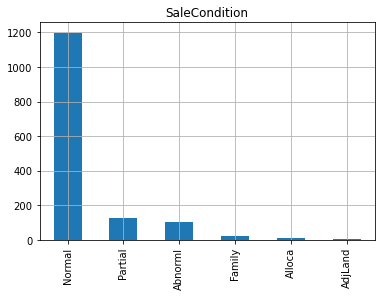

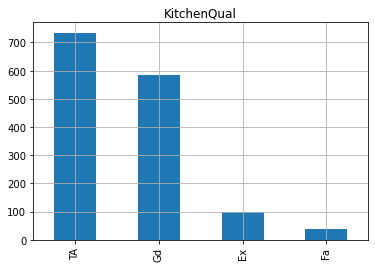

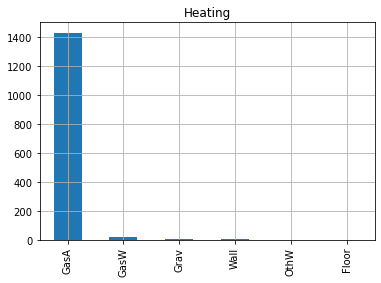

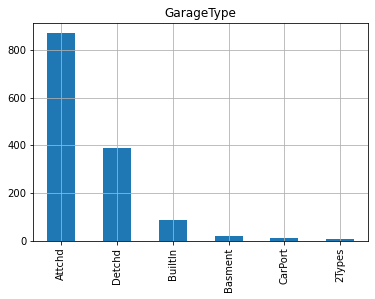

In [54]:
# make barplots for the categorical features
object_columns = data.select_dtypes(include=['object'])
for c in object_columns:
    data[c].value_counts().plot(kind='bar')
    plt.title(c)
    plt.grid()
    plt.show()

In [55]:
# drop heating
data = data.drop(['Heating'], axis=1)

In [56]:
# Sale Condition
data.SaleCondition.value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64

In [65]:
data.loc[data.SaleCondition.isin(['Alloca', 'AdjLand']), 'SaleCondition'] = 'Other'

In [66]:
data.SaleCondition.value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Other        16
Name: SaleCondition, dtype: int64

### 1.2  Separate features form the target and perform train-test split

Function `train_test_split` randomly split dataset into two parts: training data, that we will use to find optimal parameters of the model and test data, which will be used to report the final performance. 

In [67]:
from sklearn.model_selection import train_test_split

tr, te = train_test_split(data, test_size=0.2, random_state=42)

y_train = tr.SalePrice
y_test = te.SalePrice
X_train = tr.drop(['SalePrice'], axis=1)
X_test = te.drop(['SalePrice'], axis=1)

### 1.3 Encode categorical and ordinal features, scale numerical ones

In [68]:
object_columns = X_train.select_dtypes(include=['object'])
numeric_columns = X_train.select_dtypes(exclude=['object'])

object_columns.head()

,SaleCondition,KitchenQual,GarageType
254,Normal,TA,Attchd
1066,Normal,TA,Attchd
638,Normal,TA,NaN
799,Normal,Gd,Detchd
380,Normal,Gd,Detchd


In [69]:
# NA

In [70]:
numeric_columns.head()

,LotArea,OverallQual,YearRemodAdd,YearBuilt,MasVnrArea,TotalBsmtSF,GrLivArea,FullBath,GarageCars,Fireplaces,WoodDeckSF,OpenPorchSF,Age,RemodAge
254,8400,5,1957,1957,0.0,1314,1314,1,1,0,250,0,53,53
1066,7837,6,1994,1993,0.0,799,1571,2,2,1,0,40,17,16
638,8777,5,1950,1910,0.0,796,796,1,0,0,328,0,100,60
799,7200,5,1950,1937,252.0,731,1768,1,1,2,0,0,73,60
380,5000,5,1950,1924,0.0,1026,1691,2,1,1,0,0,86,60


In [71]:
# NA

In [72]:
# group cols by the preprocessing types
ordinal_cols = ['KitchenQual']
categ_cols = ['SaleCondition', 'GarageType'] 
area_cols = ['LotArea', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF']
age_cols = ['Age', 'RemodAge']

In [79]:
from unicodedata import category
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

# define the preprocessings for each group of features

ordinal_prep = OrdinalEncoder(categories=[['Fa', 'TA', 'Gd', 'Ex']])

categ_prep = make_pipeline(
    SimpleImputer(
        strategy='constant', fill_value='None'
    ),
    OneHotEncoder()
)

area_prep = make_pipeline(
    SimpleImputer(
        strategy='constant', fill_value=0.
    ),
    StandardScaler()
)

age_prep = make_pipeline(
    # no need for imputer as there is no missing values
    StandardScaler()
)

Now we need to apply different transformation to different columns. 

`ColumnTransformer` is a very usefull function, which will allow us to do that!

In [80]:
from sklearn.compose import ColumnTransformer

# define column transformer
column_transforms = ColumnTransformer([
    ('ordinal', ordinal_prep, ordinal_cols),
    ('categ', categ_prep, categ_cols),
    ('area', area_prep, area_cols),
    ('age', age_prep, age_cols),
])

## 2. Train the model

Now, we are ready to train the model. We will use `LinearRegression` model. 

In [81]:
from sklearn.linear_model import LinearRegression

# create and fit a pipeline on train dataset
pipe = make_pipeline(
    column_transforms,
    LinearRegression()
)

# make predictions on test
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

## 3. Evaluate on the test set

$$
\text{MSE} = \frac{1}{N}\sum_i \left(y_i - \hat{y}_i   \right)^2 
$$

In [91]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred)

1567787724.9760275

---


# [Optional task] Part 2. Evaluating Linear Regression

### 1. MSE,  RMSE and MAE

$$
\text{MSE} = \tfrac1N \sum_i \left(y_i - \hat{y}_i   \right)^2 
$$

$$
\text{RMSE} = \sqrt{ \tfrac1N\sum_i \left(y_i - \hat{y}_i   \right)^2 }
$$

$$
\text{MAE} = \tfrac1N \sum_i \left|y_i - \hat{y}_i   \right| 
$$

Submodule `sklearn.metrics` has most of the useful metrics implemented. Except for `RMSE`:)

In [83]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [84]:
# calculate MSE on the test

In [85]:
# calculate RMSE on the test

In [86]:
# calculate MAE on the test

### 2. Mean Squared Logarithmic Error (MSLE)

Sometimes it is useful to account for small errors in the observation with low `y` just as for the large values in the observation with large `y`.

$$
\text{MSLE} = \tfrac1N \sum_i \left(\log(y_i+1) - \log(\hat{y}_i+1)   \right)^2  = \tfrac1N \sum_i \left(\log \left(\tfrac{y_i+1}{\hat{y}_i+1}\right)  \right)^2
$$

In [87]:
from sklearn.metrics import mean_squared_log_error

# calculate MSLE on the test


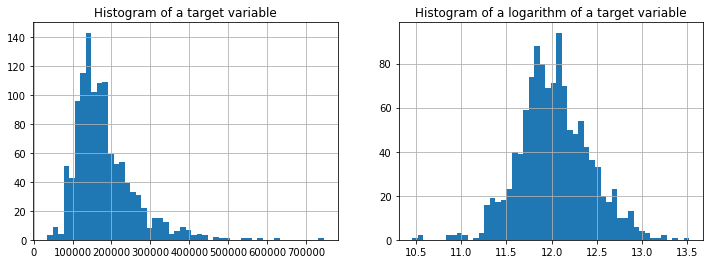

In [88]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
ax[0].hist(y_train, bins=50);
ax[0].set_title('Histogram of a target variable')
ax[0].grid()
ax[1].hist(np.log(y_train), bins=50);
ax[1].set_title('Histogram of a logarithm of a target variable')
ax[1].grid()

Looks like the logarithm of the target variable look more "normal". It may actually be helpful during training! Let's check:

- Transform the target variable ($y$ -> $\log y$) 
- Fit previously defined pipeline
- Calculate the `MSLE` and compare to the one obtained before